In [1]:
#Standard imports
import os
import cv2
import yaml
import math
import torch
import random
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from typing import Optional
import matplotlib.pyplot as plt

#PL imports
import torchmetrics
import pytorch_lightning as pl
from torchvision import transforms
from pytorch_lightning.plugins import DDPPlugin
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import DataLoader, random_split, RandomSampler, Dataset

#For PL warnings
import warnings
warnings.filterwarnings("ignore")


ModuleNotFoundError: No module named 'torchvision'

In [2]:
class Propagation_Layer(torch.nn.Module):
    '''
    A class for implementing the angular spectrum method (ASM) of wavefront propagation 
    for neural networks. Attributes used during training are registered as buffers per 
    PytorchLightning documentation.

    ... 

    Attributes
    ----------
    params : dict
        Dictionary of propagation parameters to fill out most of other attributes.
    
    batch_size : int, tensor
        Batch sized used during training.

    distance : float, tensor
        Propagation distance between layers.

    wavelength : float, tensor
        Wavelength of illumination light.

    Nx : int, tensor
        Number of DOE/SLM 'pixel elements' in the x direction.
    
    Ny : int, tensor
        Number of DOE/SLM 'pixel elements' in the y direction.

    extent_x : float, tensor
        Length of DOE/SLM in the x direction.

    extent_y : float, tensor
        Length of DOE/SLM in the y direction. 
   
    pixel_pitch : float, tensor
        Pitch (distance between) of DOE/SLM pixels.  


    Methods
    -------
    init_layer()
        Initializes the propagation plane and propagation kernel for the ASM.

    forward(wavefront, distance=None)
        Performs the ASM and returns the resulting wavefront.
    '''
    def __init__(self, params, distance):
        super().__init__()
        self.distance = distance
        self.params = params['propagator']
        self.batch_size = params['lightning']['batch_size']
        self.register_buffer('wavelength', torch.tensor(self.params['wavelength']))
        #DOE/SLM Parameters
        self.doe_params = self.params['pluto']
        self.register_buffer('Nx', torch.tensor(self.doe_params['Nx']))
        self.register_buffer('Ny', torch.tensor(self.doe_params['Ny']))
        self.register_buffer('extent_x', torch.tensor(self.doe_params['x_extent']))   
        self.register_buffer('extent_y', torch.tensor(self.doe_params['y_extent']))   
        #Initialize the propagation layer. 
        self.init_layer()
 
    def init_layer(self):
        self.register_buffer('x', torch.linspace(-self.extent_x / 2, self.extent_x / 2, self.Nx))
        self.register_buffer('y', torch.linspace(-self.extent_y / 2, self.extent_y / 2, self.Ny))

        xx,yy = torch.meshgrid(self.x, self.y)
        self.register_buffer('xx', xx.clone())
        self.register_buffer('yy', yy.clone())
 
        self.register_buffer('kx', torch.linspace(
            -math.pi * torch.div(self.Nx, 2, rounding_mode='floor') / (self.extent_x / 2), 
            math.pi * torch.div(self.Nx, 2, rounding_mode='floor') / (self.extent_x / 2),
            self.Nx
        ))
        self.register_buffer('ky', torch.linspace(
            -math.pi * torch.div(self.Ny, 2, rounding_mode='floor') / (self.extent_y / 2), 
            math.pi * torch.div(self.Ny, 2, rounding_mode='floor') / (self.extent_y / 2),
            self.Ny
        ))
        kxx, kyy =  torch.meshgrid(self.kx, self.ky)
        
        self.register_buffer('kxx', kxx.clone())
        self.register_buffer('kyy', kyy.clone()) 
        self.register_buffer('kz', torch.sqrt((2 * math.pi / self.wavelength) ** 2 - self.kxx ** 2 - self.kyy ** 2))

    def forward(self, wavefront, distance = None):
        '''
        Parameters
        ----------
        wavefront : float, tensor (Batch, Channel(2), Width, Height)
            Input wavefront to the layer. Channels are for the amplitude and phase of the
            wavefront respectively. 

        distance : float, tensor
            Distance of propation from current layer to the next. 
        '''

        if distance is not None:
            self.distance = torch.tensor(distance)
   
        amplitude = wavefront[:,0,:,:]
        phase = wavefront[:,1,:,:]

        E = amplitude[:,:,:] * torch.exp(1j * phase[:,:,:])
 
        #Get the angular spectrum at the current plane
        fft_c = torch.fft.fft2(E)
        c = torch.fft.fftshift(fft_c)

        #Multiply the angular spectrum by the propagation transfer function
        c_z = c * torch.exp(1j * self.kz * self.distance).to(c.device)

        #Compute the new wavefront
        E = torch.fft.ifft2(torch.fft.ifftshift(c_z))

        amplitude = torch.unsqueeze(torch.abs(E), 1)
        phase = torch.unsqueeze(torch.angle(E), 1)

        return torch.cat((amplitude, phase) , 1)
 

In [3]:
class cgh_overfit_dataset(Dataset):
    def __init__(self, data_path):
        self.data_path = data_path
        self.load_data()
        
        
    def __len__(self):
        return(len(self.dataset['sample']))
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        sample = self.dataset['sample'][idx]
        target = self.dataset['target'][idx]
        
        return(sample,target)

    def load_data(self):
        image = cv2.imread(self.data_path)
        image = cv2.resize(image, (224,224))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = torch.tensor(image).unsqueeze(dim=0)
        target = image / torch.max(image)
        
        sample_amplitude = torch.ones(1,1,224,224)
        sample_phase = torch.ones(1,1,224,224)
        
        sample_wavefront = torch.cat((sample_amplitude, sample_phase), dim=1)
        
        self.dataset = {'sample':sample_wavefront, 'target':target}

In [4]:
class Phase_Optimization(pl.LightningModule):
    def __init__(self, params):
        super().__init__()
        self.Nx = torch.tensor(params['propagator']['pluto']['Nx'])
        self.Ny = torch.tensor(params['propagator']['pluto']['Ny'])
        self.distance = torch.tensor(params['propagator']['distance'])
        self.wavelength = torch.tensor(params['propagator']['wavelength'])
        self.lr = params['lightning']['lr']
        self.batch_size = params['lightning']['batch_size']
        #Layers
        self.init_diffractive_layers(params)
        self.init_propagation_layers(params) 
        
    def init_diffractive_layers(self, params):
        params = params['model']
        num_layers = params['num_layers']

        self.initial_phases = [torch.nn.Parameter(torch.from_numpy(2 * np.pi * np.random.rand(1,1,self.Nx, self.Ny))) for _ in range(num_layers)]
        
        self.initial_amplitudes = [torch.nn.Parameter(torch.from_numpy(np.ones((1,1,self.Nx, self.Ny)))) for _ in range(num_layers)]
        
        for i in range(num_layers):
            self.initial_amplitudes[i].requires_grad = False
            self.register_parameter(f"phase_{i}", self.initial_phases[i])
            self.register_parameter(f"amplitude_{i}", self.initial_amplitudes[i])
            
    def init_propagation_layers(self, params):
        num_layers = params['model']['num_layers']
        self.prop_layers = [Propagation_Layer(params, self.distance) for _ in range(num_layers)]
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def criterion(self, x, y):
        loss = torch.nn.functional.mse_loss(x, y)
        return(loss)
    
    #======================================
    # Custom Functions
    #======================================
    def apply_transmission(self, wavefront, layer):
        wavefront_amplitude = wavefront[:,0,:,:]
        wavefront_phase = wavefront[:,1,:,:]
        modified_amplitude = torch.squeeze(wavefront_amplitude * layer[0])
        modified_phase = torch.squeeze(wavefront_phase + layer[1])
        temp1 = torch.unsqueeze(modified_amplitude, dim=0)
        temp2 = torch.unsqueeze(modified_phase, dim=0)

        output = torch.cat((temp1,temp2),dim=0)

        return output.unsqueeze(dim=0)
    
    #======================================
    # Dataset Things
    #======================================
    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.dataset = cgh_overfit_dataset('../images/mizzou.png')
    
    def train_dataloader(self):
        return DataLoader(self.dataset, batch_size=self.batch_size)
    
    def forward(self, x):
        #Apply Transmission
        self.x = x
        phase0 = torch.nn.functional.sigmoid(self.phase_0) * 2 * torch.pi
        self.u0 = self.apply_transmission(x, (self.amplitude_0, phase0))
        #Propagate
        self.E0 = self.prop_layers[0].forward(self.u0)
        
        return self.E0
    
    def training_step(self, batch, batch_idx):
        x,y = batch
        y = y.double()
        wavefront = self(x).squeeze()
        wavefront_ = wavefront[0] * torch.exp(1j * wavefront[1])
        image = torch.abs(wavefront_)

        loss = self.criterion(image,y)
        
        return {'loss':loss, 'pred_wavefront':wavefront, 'target':y}
    
    def training_step_end(self, outputs):
        self.wavefront = outputs['pred_wavefront']
        self.target = outputs['target']

# Begin Experiment

In [5]:
params = yaml.load(open('config.yaml'), Loader=yaml.FullLoader)

In [6]:
model = Phase_Optimization(params)

In [7]:
trainer_params = params['trainer']

if(trainer_params['gpus'] == 'None'):
    trainer = pl.Trainer(
        max_epochs = trainer_params['max_epoch'],
        progress_bar_refresh_rate = 10
    )
    
else:
    print("GPU support is not provided for this example")
    # You can experiment at your own risk with GPUs - this is not validated for
    # this example.+
    # trainer = pl.Trainer(
    #   gpus = trainer_params['gpus'],
    #    max_epochs = trainer_params['max_epoch'],
    #    accelerator = trainer_params['accelerator'],
    #    plugins = DDPPlugin(find_unused_parameters = True),
    #    progress_bar_refresh_rate = 10
    #)
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name | Type | Params
------------------------------
------------------------------
50.2 K    Trainable params
50.2 K    Non-trainable params
100 K     Total params
0.401     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

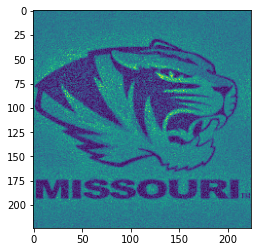

In [8]:
wavefront = model.wavefront.detach().cpu().squeeze()
wavefront = wavefront[0] * torch.exp(1j * wavefront[1])
image = torch.abs(wavefront).squeeze()
plt.imshow(image)